<a href="https://colab.research.google.com/github/rafaart/DataScienceCO/blob/develop/otimiza%C3%A7%C3%A3oCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers, models
from tensorflow.keras import mixed_precision
from sklearn.metrics import mean_squared_error


In [ ]:
# Baixar o dataset
!pip install kaggle
!kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs --force
!unzip -oq "cuhk-face-sketch-database-cufs.zip"

Dataset URL: https://www.kaggle.com/datasets/arbazkhan971/cuhk-face-sketch-database-cufs
License(s): copyright-authors
 84% 95.0M/113M [00:00<00:00, 141MB/s]
100% 113M/113M [00:00<00:00, 132MB/s] 


In [ ]:
image_folder = 'photos'
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

# Divide os arquivos em conjuntos de treino e teste (80% treino, 20% teste)
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)

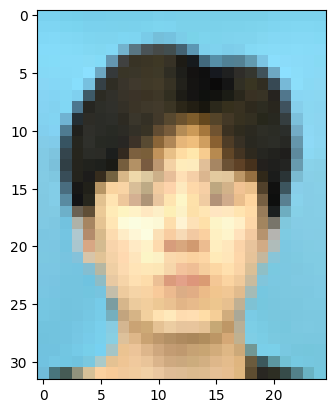

In [ ]:
# Carregamento das imagens degradadas

X_train = []
for image_file in train_files:
  try:
    img = Image.open(image_file)
    img = img.resize((25, 32))
    img_array = np.array(img) / 255.0
    X_train.append(img_array)
  except Exception as e:
    print(f"Erro ao carregar imagem {image_file}: {e}")

X_train = np.array(X_train)

plt.imshow(X_train[0])

In [ ]:
# Carregamento das imagens boas

X_good = []
for image_file in train_files:
  try:
    img = Image.open(image_file)
    img = img.resize((200, 256))
    img_array = np.array(img) / 255.0
    X_good.append(img_array)
  except Exception as e:
    print(f"Erro ao carregar imagem {image_file}: {e}")

X_good = np.array(X_good)

plt.imshow(X_good[0])

In [ ]:
# Configuração do Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

In [ ]:

# Definir o modelo CNN
"""
def build_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(32, 25, 3)))  # Dimensões originais das imagens "boas"

    # Camadas convolucionais e de upsampling
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='sigmoid'))  # Saída de 3 canais (RGB)

    return model
"""

def build_model():
    model = tf.keras.Sequential()

    # Input da imagem "ruim" com dimensões 32x24
    model.add(layers.Input(shape=(32, 25, 3)))

    # Primeira camada convolucional
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))

    # Aumentando as dimensões progressivamente com camadas de upsampling
    model.add(layers.UpSampling2D((2, 2)))  # 64x50
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))

    model.add(layers.UpSampling2D((2, 2)))  # 128x100
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))

    model.add(layers.UpSampling2D((2, 2)))  # 256x200
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))

    # Ajustando para a dimensão final (250x200)
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))

    # Saída com 3 canais (RGB) e dimensão final 250x200
    model.add(layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid'))

    return model


In [ ]:
# Construir o modelo
model = build_model()

In [ ]:
# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
print(X_good.shape)  # Verifique a forma das imagens "boas"
print(X_train.shape) # Verifique a forma das imagens "ruins"


(150, 250, 200, 3)
(150, 32, 25, 3)


In [ ]:
# Treinamento do modelo
model.fit(X_train, X_good, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/50


ValueError: Dimensions must be equal, but are 250 and 256 for '{{node compile_loss/mean_squared_error/sub}} = Sub[T=DT_FLOAT](data_1, sequential_1/conv2d_6_1/Sigmoid)' with input shapes: [?,250,200,3], [?,256,200,3].

In [ ]:
# Avaliação do modelo
# Testar com algumas imagens do conjunto de teste
for test_file in test_files[:5]:  # Testar nas primeiras 5 imagens
    img = Image.open(test_file)
    img = img.resize((25, 32))
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, 32, 25, 3)  # Adiciona dimensão para o batch

    # Prever a imagem
    pred = model.predict(img_array)

    # Visualizar a imagem original e a prevista
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Imagem Original")
    plt.imshow(img_array.squeeze())

    plt.subplot(1, 2, 2)
    plt.title("Imagem Melhorada")
    plt.imshow(pred.squeeze())
    plt.show()

Tentativa de melhoria no codigo


In [ ]:
# Ajuste automático de learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
# Transfer learning com VGG16
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in vgg.layers:
    layer.trainable = False

x = layers.Flatten()(vgg.output)
x = layers.Dense(512, activation='relu')(x)
output = layers.Dense(3, activation='sigmoid')(x)

model = Model(inputs=vgg.input, outputs=output)

In [ ]:
# Compilar o modelo
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
# Callbacks para salvar checkpoints e early stopping
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
# Treinamento com data augmentation e callbacks
# Geradores separados para treino e validação
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# O gerador de validação não precisa de augmentation
validation_datagen = ImageDataGenerator()

# Criando os geradores
train_generator = train_datagen.flow(X_train, X_train, batch_size=32)
validation_generator = validation_datagen.flow(X_train, X_train, batch_size=32)

# Ajuste no fit: passar diretamente os geradores
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,
                    callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/50


ValueError: Input 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(None, 32, 25, 3)